In [1]:
import nltk

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [2]:
from nltk.corpus import stopwords as nltk_stopwords
from nltk.stem import WordNetLemmatizer
import re

stopwords = list(nltk_stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Regular expression for filtering
regex_str = "%s|%s|%s" % (
    r"(.+)\1{2,}",                 # 3 or more repetitions of a character or multiple characters
    r"^([0-9]{1,4}[年|月|日]){1,3}$",   # Date format (year, month, day in Japanese)
    r"^[a-zA-Zあ-んア-ン!-~︰-＠]{1,2}$"   # Single characters (except for Chinese characters)
)
regex = re.compile(regex_str)

# Add additional stopwords
stopwords += ['http', 'amp']
stopwords = list(set(stopwords))

def preprocess_tweet(tweet):


    if not isinstance(tweet, str):
        return ""
    # Convert to lowercase
    tweet = tweet.lower()

    # Remove newlines and tabs
    tweet = tweet.replace('\n', ' ').replace('\t', ' ')

    # Remove URLs
    tweet = re.sub(r'https?://\S+', '', tweet)

    # Remove user mentions
    tweet = re.sub(r"@(\w+)", '', tweet)

    # Tokenize
    words = nltk.word_tokenize(tweet)

    # Process words
    processed_words = []
    for word, pos in nltk.pos_tag(words):
        # Strip punctuation
        word = word.strip(".|`|\"|,|:|;|-|?|'|'|–")

        # Skip empty strings
        if not word:
            continue

        # Lemmatize nouns (you can uncomment verb and adjective sections if needed)
        if pos.startswith("NN"):
            word = lemmatizer.lemmatize(word)
        else:
            continue

        # Filter out words based on regex, length, and stopwords
        if regex.search(word) or len(word) <= 2 or word in stopwords:
            continue

        processed_words.append(word)

    return " ".join(processed_words)

In [3]:
import pandas as pd
import numpy as np

# Load data from Excel
df = pd.read_excel('Topic_Classification_v2.xlsx')


In [4]:

# Apply the preprocessing function to the 'Tweet' column
df['processed_text'] = df['Tweet'].apply(preprocess_tweet)

# Display a sample of original and preprocessed tweets
sample_size = min(5, len(df))  # Display up to 5 samples or less if the DataFrame is smaller
sample_df = df.sample(n=sample_size, random_state=42)

for _, row in sample_df.iterrows():
    print("Original:", row['Tweet'])
    print("Preprocessed:", row['processed_text'])
    print()

# If you want to see the full DataFrame with the new column
print(df.head())

Original: RT @RepSims: A year after the insurrection it is our duty to talk about it, teach about it and explain what it was: a deadly attack on our…
Preprocessed: year insurrection duty attack our…

Original: RT @TuurDemeester: Bitcoin's launchpad: the longer we consolidate around $50k, the faster we'll rally beyond $100k. https://t.co/hMRm2FUd4Y
Preprocessed: bitcoin launchpad faster

Original: RT @RefComeOn: This is heart breaking stuff. It's times like this the GAA community need to rally around one of their own.
If you can spare…
Preprocessed: heart stuff time gaa community

Original: RT @blkwomenshealth: The effects of the insurrection at the capital are still felt a year later. This article was published in January 2021…
Preprocessed: effect insurrection capital year article

Original: RT @JackPosobiec: WATCH: Antifa setting fires outside the White House, May 2020 https://t.co/LuezB9LzJI
 https://t.co/tNUNiNaKN7
Preprocessed: watch antifa fire house

                            

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer

def compute_tfidf(documents):
    vectorizer = TfidfVectorizer(max_features=10000)
    tfidf_matrix = vectorizer.fit_transform(documents)
    return tfidf_matrix, vectorizer

tfidf_matrix, vectorizer = compute_tfidf(df['processed_text'])

In [6]:
import torch
from transformers import BertTokenizer, BertModel
import numpy as np
from sklearn.decomposition import LatentDirichletAllocation
from bertopic import BERTopic
from umap import UMAP
import gc

def lda_model(tfidf_matrix, num_topics=10):
    lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
    lda_output = lda.fit_transform(tfidf_matrix)
    return lda_output

def bert_model(documents, max_length=512, batch_size=8):
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    model = BertModel.from_pretrained('bert-base-uncased')
    device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()

    bert_outputs = []

    for i in range(0, len(documents), batch_size):
        batch = documents[i:i+batch_size]
        inputs = tokenizer(batch, return_tensors='pt', max_length=max_length, truncation=True, padding=True)
        inputs = {k: v.to(device) for k, v in inputs.items()}

        with torch.no_grad():
            outputs = model(**inputs)

        batch_outputs = outputs.last_hidden_state.mean(dim=1).cpu().numpy()
        bert_outputs.append(batch_outputs)

        # Clear some memory
        del inputs, outputs
        gc.collect()
        torch.cuda.empty_cache() if torch.cuda.is_available() else torch.mps.empty_cache() if torch.backends.mps.is_available() else None

    return np.vstack(bert_outputs)

documents = df['processed_text'].tolist()

print("Running BERT model...")
bert_embeddings = bert_model(documents)

from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(stop_words="english")
tfidf_matrix = vectorizer.fit_transform(documents)

print("Running LDA model...")
lda_output = lda_model(tfidf_matrix)

combined_output = np.hstack([lda_output, bert_embeddings])

n_samples = combined_output.shape[0]
n_neighbors = min(15, n_samples - 1)
n_components = 2

umap_model = UMAP(n_neighbors=n_neighbors, n_components=n_components, random_state=42)
topic_model = BERTopic(umap_model=umap_model)

topics, probs = topic_model.fit_transform(documents, embeddings=combined_output)

topic_info = topic_model.get_topic_info()
print("Number of topics: {}".format( len(topic_info)))

if topic_info.empty:
    print("Topic information is empty. Visualization cannot proceed.")
else:
    print(topic_info)

Running BERT model...
Running LDA model...
Number of topics: 111
     Topic  Count                                        Name  \
0       -1   1883           -1_insurrection_day_trump_traitor   
1        0    378                     0_punjab_modi_bjp_rally   
2        1    216   1_socialism_communism_capitalism_business   
3        2    139                   2_news_should_paper_gaetz   
4        3    119                  3_trump_for_georgia_donald   
..     ...    ...                                         ...   
106    105     11                 105_fire_watch_house_antifa   
107    106     11  106_coconspirators_in_consequence_handcuff   
108    107     11                   107_photo_our_be_investor   
109    108     10           108_france_padyatra_cycle_vehicle   
110    109     10                109_price_stock_monday_apple   

                                        Representation  \
0    [insurrection, day, trump, traitor, people, de...   
1    [punjab, modi, bjp, rally, feroze

In [17]:
import matplotlib.pyplot as plt
import plotly.express as px

# Check if topic_info is not empty
if not topic_info.empty:
    fig = px.bar(topic_info, x='Name', y='Count', title='Topic Distribution')
    fig.update_xaxes(tickangle=-45)
    fig.show()
else:
    print("Topic information is empty. Unable to visualize topics.")

In [19]:
topic_info = topic_model.get_topic_info()
print("Number of topics: {}".format( len(topic_info)))
topic_info.head(10)

Number of topics: 111


,Topic,Count,Name,Representation,Representative_Docs
0,-1,1883,-1_insurrection_day_trump_traitor,"[insurrection, day, trump, traitor, people, de...",[democrat party democrat blm/antifa terrorist ...
1,0,378,0_punjab_modi_bjp_rally,"[punjab, modi, bjp, rally, ferozepur, singh, m...","[modi rally punjab modi, modi rally punjab mod..."
2,1,216,1_socialism_communism_capitalism_business,"[socialism, communism, capitalism, business, s...","[socialism, socialism, socialism]"
3,2,139,2_news_should_paper_gaetz,"[news, should, paper, gaetz, thought, desantis...",[trump plan news conference anniversary insurr...
4,3,119,3_trump_for_georgia_donald,"[trump, for, georgia, donald, investigation, t...",[day attack capitol president trump georgia fo...
5,4,101,4_defendant_seditio_carlson_fanone,"[defendant, seditio, carlson, fanone, forgiven...",[cruz tucker carlson forgiveness jan insurrect...
6,5,76,5_ccp_vigil_rioting_radical,"[ccp, vigil, rioting, radical, offic, minion, ...",[dems candlelight vigil democracy today radica...
7,6,62,6_que_para_los_del,"[que, para, los, del, por, con, etapa, carlos,...",[indultos reverencias para los golpistas peaje...
8,7,62,7_anni_press_conference_breaking,"[anni, press, conference, breaking, trump, smi...",[breaking trump press conference jan insurrect...
9,8,57,8_white_memorial_they_panic,"[white, memorial, they, panic, black, simple, ...","[white white traitor race black, white white t..."


In [16]:
a_topic = topic_info.iloc[0]["Topic"] # Select the 1st topic
topic_model.get_topic(a_topic) # The words and their c-TF-IDF scores

[('insurrection', 0.009583822824076962),
 ('day', 0.007740435515708466),
 ('trump', 0.0077373317198075175),
 ('traitor', 0.00771927861167631),
 ('people', 0.007443394628427895),
 ('democracy', 0.007270318730907656),
 ('year', 0.00709551109463329),
 ('jan', 0.007022302140619697),
 ('capitol', 0.006384469891300216),
 ('antifa', 0.006282832833482966)]

In [20]:
topic_model.visualize_barchart(top_n_topics=10)

In [21]:
topic_model.visualize_topics()

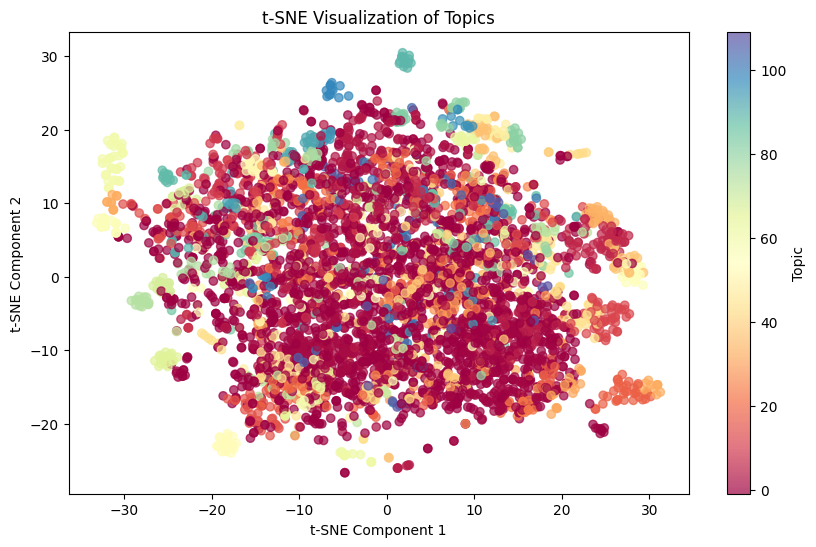

In [26]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

def apply_dimensionality_reduction(data, pca_components=50, tsne_components=3):

    # Apply PCA to reduce dimensionality
    pca = PCA(n_components=pca_components)
    pca_result = pca.fit_transform(data)

    # Apply t-SNE for further reduction to 2D
    tsne = TSNE(n_components=tsne_components, random_state=42)
    tsne_result = tsne.fit_transform(pca_result)

    return pca_result, tsne_result

# Apply dimensionality reduction
pca_result, tsne_result = apply_dimensionality_reduction(combined_output)

# Visualization of t-SNE result
plt.figure(figsize=(10, 6))
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=topics, cmap='Spectral', alpha=0.7)
plt.colorbar(label='Topic')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE Visualization of Topics')
plt.show()

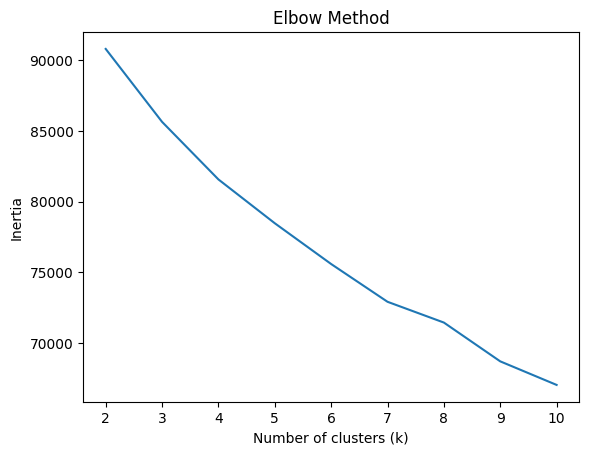

Optimal number of clusters: 2
Cluster labels shape: (5297,)


In [27]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

def apply_kmeans(data, max_k=10):
    inertias = []
    silhouette_scores = []

    for k in range(2, max_k+1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(data)
        inertias.append(kmeans.inertia_)
        silhouette_scores.append(silhouette_score(data, kmeans.labels_))

    # Plot Elbow curve
    plt.plot(range(2, max_k+1), inertias)
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Inertia')
    plt.title('Elbow Method')
    plt.show()

    # Choose optimal k (you might want to implement a more sophisticated method)
    optimal_k = silhouette_scores.index(max(silhouette_scores)) + 2

    # Final clustering with optimal k
    final_kmeans = KMeans(n_clusters=optimal_k, random_state=42)
    labels = final_kmeans.fit_predict(data)

    return labels, optimal_k

cluster_labels, optimal_k = apply_kmeans(pca_result)
print(f"Optimal number of clusters: {optimal_k}")
print(f"Cluster labels shape: {cluster_labels.shape}")